### Imports

In [2]:
!pip -q install pm4py
!apt -q install graphviz

Reading package lists...
Building dependency tree...
Reading state information...
graphviz is already the newest version (2.42.2-6).
0 upgraded, 0 newly installed, 0 to remove and 9 not upgraded.


In [3]:
import pm4py
import pandas as pd
import os
import pprint as pp
import uuid
import networkx as nx
import numpy as np
import time

from pm4py.algo.simulation.playout.petri_net import algorithm as simulator
from pm4py.objects.petri_net.utils.final_marking import discover_final_marking
from pm4py.objects.petri_net.utils.initial_marking import discover_initial_marking

from pm4py.objects.petri_net.obj import PetriNet
from pm4py.objects.petri_net.utils import petri_utils
from pm4py.objects.petri_net.utils.petri_utils import get_transition_by_name
from pm4py.objects.petri_net.utils.final_marking import discover_final_marking
from pm4py.objects.petri_net.utils.initial_marking import discover_initial_marking
from pm4py.algo.conformance.alignments.petri_net import algorithm as alignments
from pm4py.algo.conformance.tokenreplay import algorithm as token_based_replay
from pm4py.objects.bpmn.layout.variants.graphviz import Parameters as bpmn_layouter_parameters
from pm4py.objects.bpmn.layout import layouter as bpmn_layouter
from pm4py.objects.bpmn.exporter import exporter as bpmn_exporter

from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator

from pm4py.objects.petri_net.utils import align_utils

### Helper Funtions

In [27]:
def get_trace(number, trace_sequence):
  case_id = []
  for i in trace_sequence:
    case_id.append(number)
  trace_data = {
    'case_id': case_id,
    'activity': trace_sequence,
    'timestamp': pd.date_range('20130101 09:00','20130110 16:00', periods = len(trace_sequence))}
  return pd.DataFrame(trace_data)

# Demo data
def get_example_log():
  trace_1 = get_trace(1,['a', 'e', 'b',  'g','c', 'd'])
  trace_2 = get_trace(3,['a', 'e', 'f', 'b', 'c', 'd'])
  trace_3 = get_trace(4,['a', 'b', 'c', 'e', 'g', 'd'])
  trace_4 = get_trace(2,['a', 'b', 'e', 'c', 'f', 'd'])
  trace_5 = get_trace(6,['a', 'e', 'b', 'c', 'g', 'h', 'c', 'd'])
  trace_6 = get_trace(7,['a', 'e', 'b', 'g', 'r','d'])

  log_frame = pd.concat([trace_1, trace_2, trace_3, trace_4, trace_5, trace_6], ignore_index=True)
  log_frame['timestamp'] = pd.date_range('20130101 09:00','20130110 16:00', periods = log_frame. shape[0])

  return pm4py.format_dataframe(pd.DataFrame(data=log_frame), case_id='case_id', activity_key='activity', timestamp_key='timestamp')

### Repair algo

#### Process Model Repair Helper Functions

In [38]:

def get_place_by_name(net: PetriNet, place_name):
    for p in net.places:
        if p.name == place_name:
            return p
    return None


# Get all the traces from a given log as a dictionary
# Key is the trace name
# Value is the corresponding log snippet sorted by time stamp
def get_traces_from_log(log):
    traces = {}
    for case_id in log['case:concept:name'].unique():
        trace = log[log['case:concept:name'] == case_id]
        trace = trace.sort_values(by=['time:timestamp'])
        traces[case_id] = trace
    return traces


# Returns true if the given trace fits the given process model
def trace_is_fit(trace, net, im, fm):
    fitness = pm4py.conformance.fitness_alignments(trace, net, im, fm)
    return fitness['averageFitness'] == 1.0


def get_reached_marking(trace, net, im, fm):
    parameters_tbr = {token_based_replay.Variants.TOKEN_REPLAY.value.Parameters.STOP_IMMEDIATELY_UNFIT: True}#, token_based_replay.Variants.TOKEN_REPLAY.value.Parameters.WALK_THROUGH_HIDDEN_TRANS: True}
    fitness = token_based_replay.apply(trace, net, im, fm, parameters=parameters_tbr)
    return fitness[0]['reached_marking']


# Returns the alignment between the given trace and the given process model as a list of tuples
def get_alignment(trace, net, im, fm):
    alignment = pm4py.conformance_diagnostics_alignments(trace,
                                                         net,
                                                         im,
                                                         fm,
                                                         variant_str=alignments.VERSION_DISCOUNTED_A_STAR)
    return alignment[0]['alignment']


# Returns true if the given move is a synchronous move
def is_sync_move(move):
    return move[0] == move[1] and move[0] != '>>' and move[1] != '>>'


# Returns true if the given move is a move on log
def is_move_on_log(move):
    return move[0] != move[1] and move[0] != '>>' and move[1] == '>>'


# Returns true if the given move is a move on model
def is_move_on_model(move):
    return move[0] != move[1] and move[0] == '>>' and move[1] != '>>'


# Returns true if the given move is a move on model and involves a skip / hidden transition
def is_move_on_model_skip(move):
    return is_move_on_model(move) and move[1] is None


# Returns net with an additional skip transition connected to the given in_places and out_places
# The skip transition's name should be unique
def add_skip_transition(net, in_place, out_place, skip_transition_name):
    petri_utils.add_transition(net, name=skip_transition_name, label=None)
    new_from_transition = get_transition_by_name(net, skip_transition_name)
    petri_utils.add_arc_from_to(in_place, new_from_transition, net)
    petri_utils.add_arc_from_to(new_from_transition, out_place, net)
    return net


def get_transition_by_label(net: PetriNet, transition_label):
    for t in net.transitions:
        if t.label == transition_label:
            return t
    return None


# Input: net and a list of names of transitions to be skipped in that net
# Output: net with the transitions skipped by skip transitions with same in_places and out_places as skipped transitions
def skip_transition(net, transition_to_be_skipped_name):
    SKIP_NODE_BASE_NAME = "skip_transition_skip_BASE_NAME_"

    transition_to_be_skipped = get_transition_by_label(net, transition_to_be_skipped_name)
    in_arcs = transition_to_be_skipped.in_arcs
    out_arcs = transition_to_be_skipped.out_arcs
    # The SKIP_NODE_BASE_NAME + transition is a unique name since transitions to be skipped is a set
    petri_utils.add_transition(net, name=SKIP_NODE_BASE_NAME + str(transition_to_be_skipped_name), label=None)
    new_transition = get_transition_by_name(net, SKIP_NODE_BASE_NAME + str(transition_to_be_skipped_name))
    for arc in in_arcs:
        petri_utils.add_arc_from_to(arc.source, new_transition, net)
    for arc in out_arcs:
        petri_utils.add_arc_from_to(new_transition, arc.target, net)
    return net


# Input: Dictionary of unfit traces where trace name is the key and trace is the value,
# petri net wit initial and final markings
# Output: Set of transitions to be skipped to repair moves on model
def get_transitions_to_be_skipped(traces_to_be_repaired, net, im, fm):
    transitions_to_be_skipped = set()
    print("Checking traces for skips ", end="", flush=True)
    for trace_key, trace in traces_to_be_repaired.items():
        print("|", end="", flush=True)
        # Calculate the alignment between the trace and the process model
        alignment = get_alignment(trace, net, im, fm)

        # If it is a move on model (e.g.: (>>, a)), add the skipped transition to a set of transitions to be skipped
        # Ignore synchronous moves (e.g.: (a, a)), and moves on log (e.g.: (a, >>)) for now
        transitions_to_be_skipped.update(
            set(map(lambda y: y[1], filter(lambda z: z[1] != None, filter(lambda x: x[0] == '>>' and x[1] != '>>', alignment)))))
    print('')
    return transitions_to_be_skipped


# Create map of last place reached as key and sub-log dataframe of sub-traces as value
def get_sublogs_with_places(traces_to_be_repaired, event_log, net, im, fm):
    sublogs = {}
    print("Checking traces for sub-traces ", end="", flush=True)
    for trace_key, trace in traces_to_be_repaired.items():
        print("|", end="", flush=True)
        # Continue with next trace, if model is already repaired for current trace based on token based replay
        if trace_is_fit(trace, net, im, fm):
            continue

        # The move_on_log_sub-trace dataframe temporarily stores the sub-trace of moves on log
        # before a synchronous move is reached
        move_on_log_subtrace = pd.DataFrame(columns=event_log.columns)
        sync_moves_subtrace = pd.DataFrame(columns=event_log.columns)

        # Store the last markings reached initialised with the start place of the petri net.
        # This helps with not needing to do a full token based replay for each sub-trace.
        last_reached_marking = im

        # Identify all sub-traces of moves on log using the alignment and save them in the sub-traces map
        alignment = get_alignment(trace, net, im, fm)

        # Last item fix
        alignment_len = len(alignment) - 1
        for index, element in enumerate(alignment):
            # If it is a synchronous move (e.g.: (a, a)):

            if is_sync_move(element):
                # If move_on_log_subtrace is not empty, this means, that the current alignment step ends a sub-trace,
                # thus save the sub-trace to the sub-traces map with the last place reached as key
                if not move_on_log_subtrace.empty:
                    # Get last reached marking of the sub-trace.
                    # This corresponds to the marking reached before the sub-trace of moves on log started
                    last_reached_marking = get_reached_marking(sync_moves_subtrace, net, im, fm)

                    # save the sub-trace of moves on log in the sub-traces map with the last place reached as key
                    sublogs[last_reached_marking] = pd.concat(
                        [sublogs.get(last_reached_marking, pd.DataFrame(columns=event_log.columns)),
                         move_on_log_subtrace], ignore_index=True)

                    # Reset the move_on_log_subtrace to be ready for the next potential sub-trace
                    move_on_log_subtrace = pd.DataFrame(columns=event_log.columns)
                # Drop first activity in event log
                # (this should correspond to the sync move in the alignment element currently at hand) &
                # continue with the next element
                sync_moves_subtrace = pd.concat([sync_moves_subtrace, trace.iloc[0].to_frame().T], ignore_index=True)
                trace = trace.iloc[1:]

            # If it is a move on log (e.g.: (a, >>)):
            elif is_move_on_log(element):
                # append it to the dataframe of moves on log and remove it from the trace
                # to_frame().T transforms the series resulting form the iloc[0] operation to a dataframe with one row
                move_on_log_subtrace = pd.concat([move_on_log_subtrace, trace.iloc[0].to_frame().T], ignore_index=True)
                trace = trace.iloc[1:]

                if index == alignment_len:
                    # Get last reached marking of the sub-trace.
                    # This corresponds to the marking reached before the sub-trace of moves on log started
                    last_reached_marking = get_reached_marking(sync_moves_subtrace, net, im, fm)

                    # save the sub-trace of moves on log in the sub-traces map with the last place reached as key
                    sublogs[last_reached_marking] = pd.concat(
                        [sublogs.get(last_reached_marking, pd.DataFrame(columns=event_log.columns)),
                         move_on_log_subtrace], ignore_index=True)

                    # Reset the move_on_log_subtrace to be ready for the next potential sub-trace
                    move_on_log_subtrace = pd.DataFrame(columns=event_log.columns)


            # Ignore all other alignment elements (e.g.: (>>, a)), since they have been fixed in previous steps
            else:
                if index == alignment_len:
                    # Get last reached marking of the sub-trace.
                    # This corresponds to the marking reached before the sub-trace of moves on log started
                    last_reached_marking = get_reached_marking(sync_moves_subtrace, net, im, fm)

                    # save the sub-trace of moves on log in the sub-traces map with the last place reached as key
                    sublogs[last_reached_marking] = pd.concat(
                        [sublogs.get(last_reached_marking, pd.DataFrame(columns=event_log.columns)),
                         move_on_log_subtrace], ignore_index=True)

                    # Reset the move_on_log_subtrace to be ready for the next potential sub-trace
                    move_on_log_subtrace = pd.DataFrame(columns=event_log.columns)
                continue
    print("")
    return sublogs


# Greedy algorithm to optimize the sublogs
# Input: sublogs in the form of a dictionary with the key being markings and the value being corresponding sublogs
# Output: optimized sublogs in the form of a dictionary with the key being a place and the value being sublog
#         The sub-log is optimized in the sense that the places are disjoint,
#         meaning the net can be fixed in as few places as possible, while the sublogs are still complete
def optimize_sublogs(sublogs):
    # Create empty dictionary to store optimized sublogs
    optimized_sublogs = {}

    while len(sublogs) > 0:
        # Create empty dictionary to store place count as value and place as key
        place_count = {}
        # get all keys from sublogs
        keys = list(sublogs.keys())
        # Flatten the keys to a list of places
        places = [item for sublist in keys for item in sublist]

        # Count the occurrences of each place in the list of places
        for place in places:
            place_count[place] = place_count.get(place, 0) + 1

        # get key of maximum count
        max_count_place = max(place_count, key=place_count.get)
        # List of keys to delete
        keys_to_delete = []
        # Union all values of sublogs with max_count_place in key and
        # store in optimized_sublogs with max_count_place as key
        for key, value in sublogs.items():
            if max_count_place in key:
                optimized_sublogs[max_count_place] = pd.concat(
                    [optimized_sublogs.get(max_count_place, pd.DataFrame(columns=value.columns)), value],
                    ignore_index=True)
                # mark key for deletion
                keys_to_delete.append(key)
        # delete all marked keys from sublogs
        for key in keys_to_delete:
            del sublogs[key]

    return optimized_sublogs


def merge_and_connect_at_place(net, im, fm, sub_net, sub_im, sub_fm, place):
    SUBPROCESS_BASE_NAME = "subprocess_"
    # Merge & connect the sub-net to the original petri net
    net = petri_utils.merge(net, [sub_net])
    # Extract the start place and final of the sub-process net. This assumes that there is only on of each
    sub_start_place = list(sub_im.keys())[0]
    sub_final_place = list(sub_fm.keys())[0]
    sub_start_place_out_arcs = list(sub_start_place.out_arcs)
    sub_final_place_in_arcs = list(sub_final_place.in_arcs)

    # Connect the sub_net with the net at the place
    if ((len(sub_start_place_out_arcs)==1) and (sub_start_place_out_arcs[0].target.label == None)):
      petri_utils.add_arc_from_to(place, sub_start_place_out_arcs[0].target, net)
      petri_utils.remove_place(net, sub_start_place)
    else:
      net = add_skip_transition(net, place, sub_start_place, SUBPROCESS_BASE_NAME + '_from_' + place.name)

    if ((len(sub_final_place_in_arcs)==1) and (sub_final_place_in_arcs[0].source.label == None)):
      petri_utils.add_arc_from_to(sub_final_place_in_arcs[0].source, place, net)
      petri_utils.remove_place(net, sub_final_place)
    else:
      net = add_skip_transition(net, sub_final_place, place, SUBPROCESS_BASE_NAME + '_to_' + place.name)

    return net, im, fm

# Input: Petri Net, two places and a transition, that should connect them
# Output: Petri net with the two places connected via a copy of the transition
def connect_places_via_transition(net, transition, from_place, to_place):
    petri_utils.add_transition(net, name=transition.name, label=transition.label)
    added_transition = get_transition_by_name(net, transition.name)
    petri_utils.add_arc_from_to(from_place, added_transition, net)
    petri_utils.add_arc_from_to(added_transition, to_place, net)
    return net


# Extract one place from a given marking
def extract_place_from_marking(marking):
    return list(marking.keys())[0]


#### Process Model Repair Algorithm


In [39]:
# This Algorithm implements the process model repair Algorithm
# proposed by the paper "Repairing process models to reflect reality" by Dirk Fahland and Wil van der Aalst
# Input: petri net, initial marking, final marking, event log
# Output: repaired process model
def repair_process_model(net, im, fm, event_log):

    # Extract the different traces from the event log
    traces = get_traces_from_log(event_log)

    # Identify the traces that are not fitting the process model:
    traces_to_be_repaired = {k: v for k, v in traces.items() if not trace_is_fit(v, net, im, fm)}

    # 1. Fix all moves on model
    # Identify the transitions to be skipped
    transitions_to_be_skipped = set()
    # Identify the transitions to be skipped
    transitions_to_be_skipped = get_transitions_to_be_skipped(traces_to_be_repaired, net, im, fm)

    # Skip all transitions to be skipped by adding a new invisible "None" transition to the process model
    # with the same input and output places as the transition to be skipped
    for transition in transitions_to_be_skipped:
        skip_transition(net, transition)

    # Alignment of net and traces now do not contain any moves on model besides moves on hidden (None) transitions

    # 2. Fix all moves on log
    # Create map of last place reached as key and sub-log dataframe of sub-traces as value
    sublogs = get_sublogs_with_places(traces_to_be_repaired, event_log, net, im, fm)
    # 3. Optimise the sublogs
    sublogs = optimize_sublogs(sublogs)

    # 4. Repair the model for each sublog, by discovering the process model of the sublog and
    # merging it into the original petri net at the last place reached before the sublog started (enabling place)
    for place, sublog in sublogs.items():
        sub_net, sub_im, sub_fm = pm4py.discover_petri_net_inductive(sublog, activity_key='concept:name',
                                                                     case_id_key='case:concept:name',
                                                                     timestamp_key='time:timestamp')
        net, im, fm = merge_and_connect_at_place(net, im, fm, sub_net, sub_im, sub_fm, place)

    # 5. Return the repaired process model
    return net, im, fm

### Example

BPMN model running example:


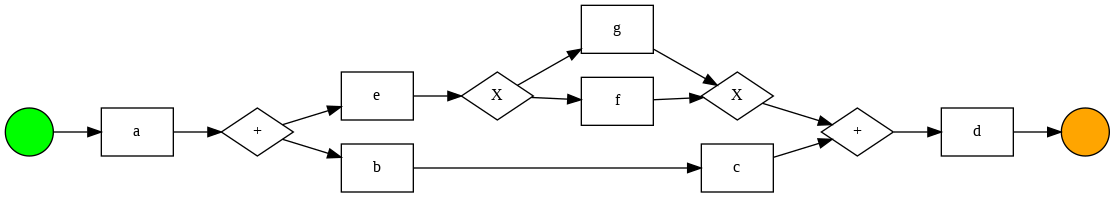

Petri net running example:


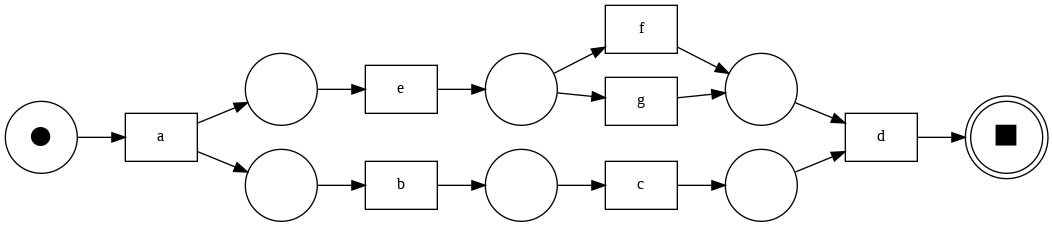

In [40]:
# Import Models
PATH = 'YOUR_PATH'

bpmn = pm4py.read_bpmn(f'{PATH}Running_Example.bpmn')
net, im, fm = pm4py.convert_to_petri_net(bpmn)
print("BPMN model running example:")
pm4py.view_bpmn(bpmn)
print("Petri net running example:")
pm4py.view_petri_net(net, im, fm)

These are the alignments.

In [41]:
log = get_example_log()
aligned_traces = pm4py.conformance_diagnostics_alignments(log, net, im, fm)
print('Alignments:')
align_utils.pretty_print_alignments(aligned_traces)

<ipython-input-27-c734229c37e1>:23: DeprecatedWarning: format_dataframe is deprecated as of 2.3.0 and will be removed in 3.0.0. the format_dataframe function does not need application anymore.
  return pm4py.format_dataframe(pd.DataFrame(data=log_frame), case_id='case_id', activity_key='activity', timestamp_key='timestamp')


aligning log, completed variants ::   0%|          | 0/6 [00:00<?, ?it/s]

Alignments:
 a | e | b | g | c | d |
------------------------
 a | e | b | g | c | d |


 a | b | e | c | f | d |
------------------------
 a | b | e | c | f | d |


 a | e | f | b | c | d |
------------------------
 a | e | f | b | c | d |


 a | b | c | e | g | d |
------------------------
 a | b | c | e | g | d |


 a  | e  | b  | c  | g  | h  | c  | d  |
----------------------------------------
 a  | e  | b  | c  | g  | >> | >> | d  |


 a  | e  | b  | >> | g  | r  | d  |
-----------------------------------
 a  | e  | b  | c  | g  | >> | d  |




Repair the Petri net.

Checking traces for skips ||
Checking traces for sub-traces ||


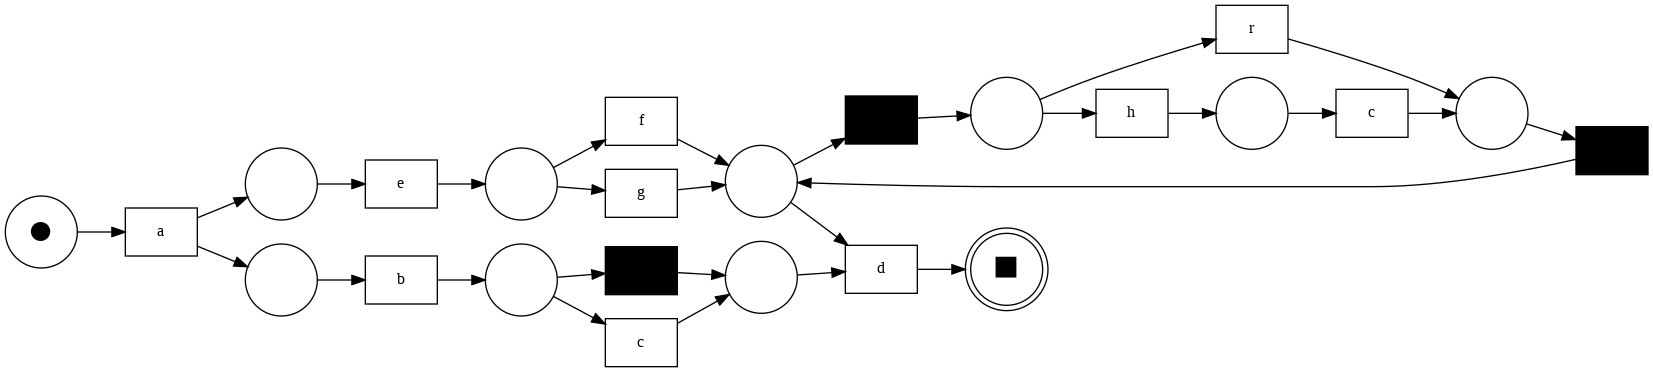

In [42]:
net_rep, im_rep, fm_rep = repair_process_model(net, im, fm, log)
pm4py.view_petri_net(net_rep, im_rep, fm_rep)

Convert repaired Petri net to BPMN model.

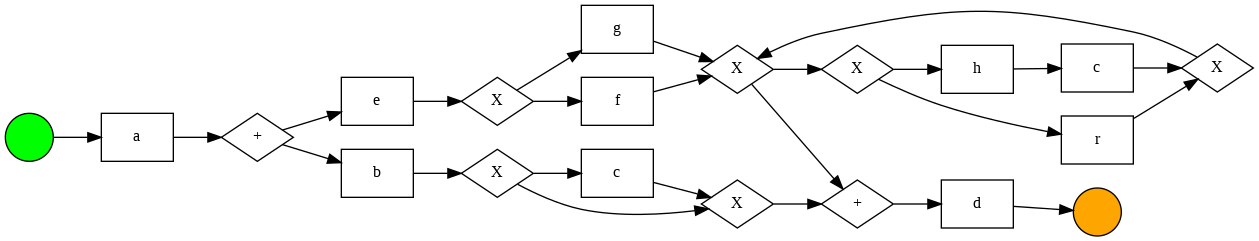

In [43]:
bpmn_rep = pm4py.convert_to_bpmn(net_rep, im_rep, fm_rep)
pm4py.view_bpmn(bpmn_rep)

Petri net discovered from example event log using the Inductive Miner:


<ipython-input-27-c734229c37e1>:23: DeprecatedWarning: format_dataframe is deprecated as of 2.3.0 and will be removed in 3.0.0. the format_dataframe function does not need application anymore.
  return pm4py.format_dataframe(pd.DataFrame(data=log_frame), case_id='case_id', activity_key='activity', timestamp_key='timestamp')


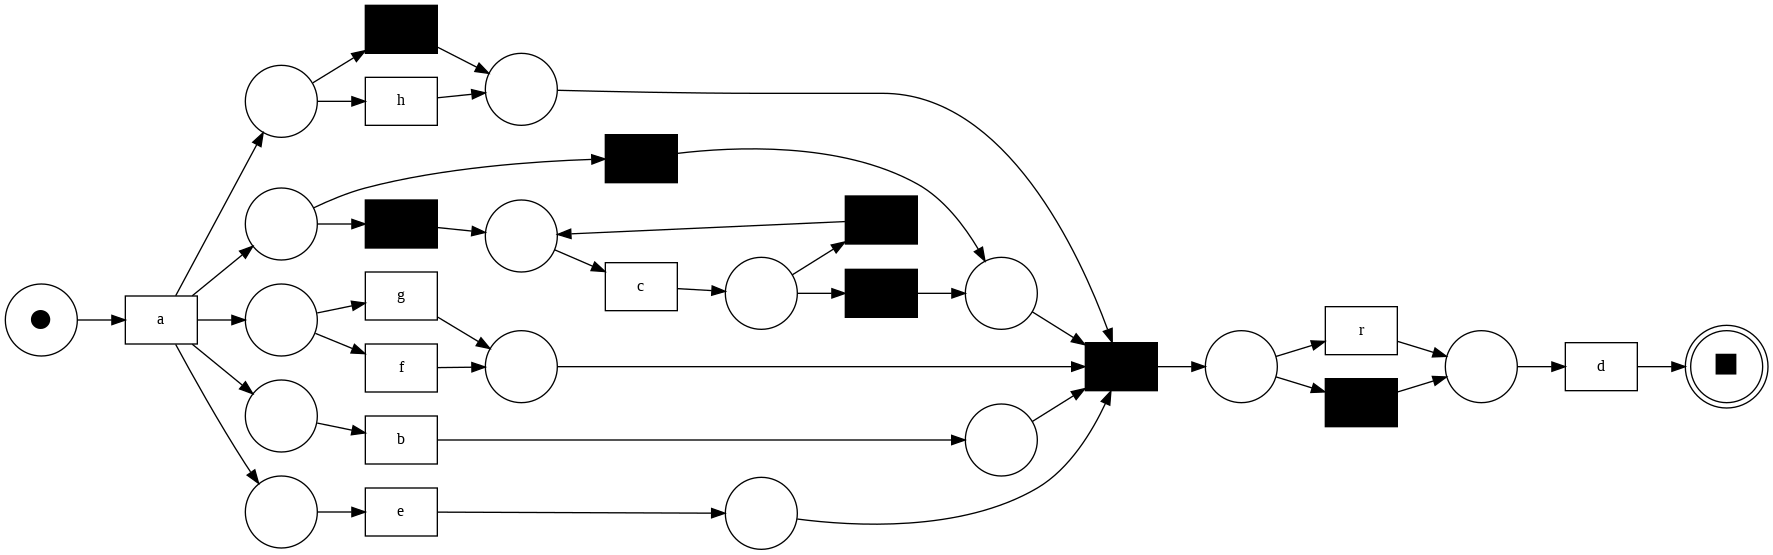

BPMN model obtain from the Petri net discovered using the Inductive Miner:


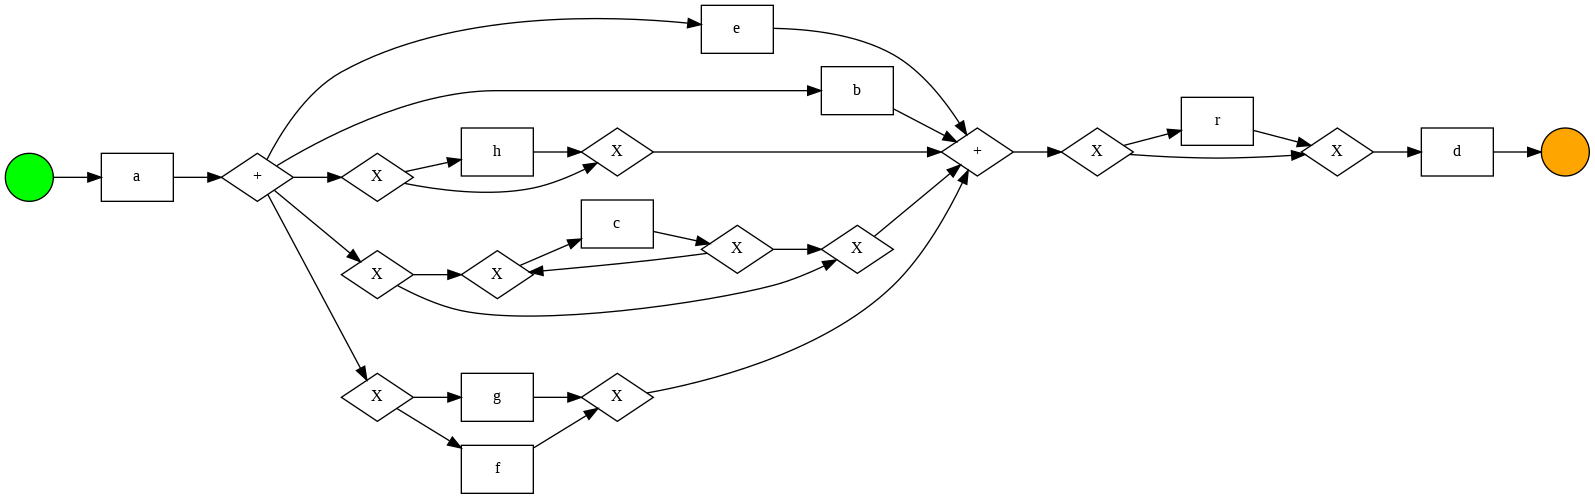

In [44]:
ind_net, ind_im, ind_fm = pm4py.discover_petri_net_inductive(get_example_log())
print('Petri net discovered from example event log using the Inductive Miner:')
pm4py.view_petri_net(ind_net, ind_im, ind_fm)
print('BPMN model obtain from the Petri net discovered using the Inductive Miner:')
pm4py.view_bpmn(pm4py.convert_to_bpmn(ind_net, ind_im, ind_fm))